# Text Generation using Recurrent Neural Network

### Content
- [1. Mounting the google drive to google colab](#1.-Mounting-the-google-drive-to-google-colab)
- [2. Standard Imports for Recurrent Neural Networks](#2.-Standard-Imports-for-Recurrent-Neural-Networks)
- [3. Loading the txt file that is used for RNN](#3.-Loading-the-txt-file-that-is-used-for-RNN)
- [4. Exploring text dataset](#4.-Exploring-text-dataset)
- [5. Numerical encode the sentences and features](#5.-Numerical-encode-the-sentences-and-features)
- [6. train-test-split X and y](#6.-train-test-split-X-and-y)
- [7. Create RNN model](#7.-Create-RNN-model)
- [8. Creating ModelCheckpoint and callback requirements](#8.-Creating-ModelCheckpoint-and-callback-requirements)
- [9.Training my RNN model](#9.Training-my-RNN-model)
- [10. evaluating performance of model](#10.-evaluating-performance-of-model)
  - [10.1 Training Accuracy & Loss](#10.1-Training-Accuracy-&-Loss)
  - [10.2 Testing Accuracy & Loss](#10.2-Testing-Accuracy-&-Loss)
  - [10.3 Plotting train and test together](#10.3-Plotting-train-and-test-together)
- [11. Loading my pre-trained weights to resume training](#11.-Loading-my-pre-trained-weights-to-resume-training)
- [12.Try generating text using help from keras.io](#12.Try-generating-text-using-help-from-keras.io)
- [13. Try correct spelling of generating text using TextBlob](#13.-Try-correct-spelling-of-generating-text-using-TextBlob)
- [14. Evaluation with other model runs & Conclusion](#14.-Evalulation-with-other-model-runs-&-Conclusion)

### 1.  Mounting the google drive to google colab

In [ ]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [ ]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
# plot model architecture
#from .keras.utils import plot_model

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback, EarlyStopping

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used for RNN

- rating 5.0 `reviews` for 'Python for Everybody' course from Coursera is converted to text format
- it is preprocessed to remove url links, emoji. alphabets, spacing and necessary punctuations remains.

In [ ]:
# cd to pull my txt file from my google drive into google colab
#%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep punctuations this time
data = re.sub("[^a-zA-Z.,?!'\";:-]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

### 4. Exploring text dataset

- there are a total of 36 characters which includes spacing, alphabets and necessary punctuations
- these unique characters are mapped to numerical values & vice-versa.
- the numerical values are then mapped into np.zeros array for feeding into the RNN model
- the output will be predicted np.zeros array which will be mapped back to numerical values and back to characters

In [ ]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  36


In [ ]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 ':': 7,
 ';': 8,
 '?': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [ ]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

### 5. Numerical encode the sentences and features

- the numerical mapping will be encoded using np.zeros
- maxlen=100, means the text input into the RNN model will be 100 characters long

In [ ]:
len(data)

1208987

In [ ]:
text = data

In [ ]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402963


In [ ]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming. attentive save the ', 't auditing this course helped me a lot in learning this language programming. attentive save the mon', 'uditing this course helped me a lot in learning this language programming. attentive save the money ', 'ting this course helped me a lot in learning this language programming. attentive save the money i w', 'g this course helped me a lot in learning this language programming. attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [ ]:
len(text)

1208987

In [ ]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### 6. train-test-split X and y

X and y are split into train and test sets, **shuffle=False** is used as reviews are written in a sequence

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 7. Create RNN model

model is created as a function for saving checkpoints in the future referenced from [source](https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6)
- model is instantiated with: 
  - Sequential(), 
  - then added in a LSTM layer batches of 128, input shape=(100, 36)
  - then added a Dense layer with 36 characters which the RNN is trying to predict
  - then a final Activation 'softmax' as the is a multi-class classification/prediction
  
- model is compiled with:
  - loss = 'categorical_crossentropy' as it is multi-class classification
  - optimizer='adam' which is standard
  - metrics=['accuracy'] for classification

In [ ]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(GRU(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [ ]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               63744     
_________________________________________________________________
dense (Dense)                (None, 36)                4644      
_________________________________________________________________
activation (Activation)      (None, 36)                0         
Total params: 68,388
Trainable params: 68,388
Non-trainable params: 0
_________________________________________________________________


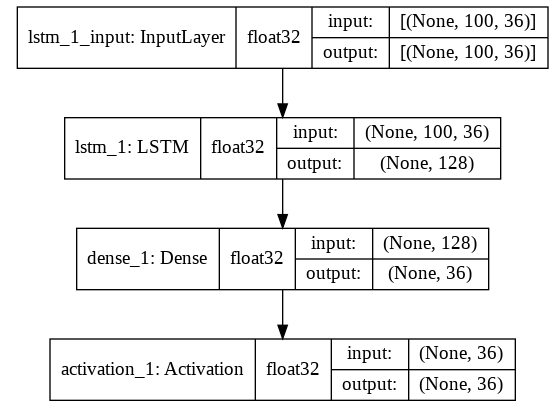

In [ ]:
from IPython.display import Image
Image(filename='model topology.png')

### 8. Creating my ModelCheckpoint and callback requirements

- checkpoint path to save weights and best model if disconnection occurs while fitting

In [ ]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
    [source](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)

- adjust the temperature parameter to generate more or less random predictions when trying to generate text[source](https://www.tensorflow.org/tutorials/text/text_generation)
- when temperature =1, means the samples produced will be more diverse


In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

- the function generates text after each epoch, so we can monitor the progress of the model by the semantics of the text generated

In [ ]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr, es]

### 9.Training my RNN model

- model is trained for 100 epoch

In [ ]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 57s 10ms/step - loss: 2.3328 - accuracy: 0.3442 - val_loss: 1.4882 - val_accuracy: 0.5762

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "arles russell severance. i learned comfortably throughout the course and was able to write some cool"
arles russell severance. i learned comfortably throughout the course and was able to write some coolle way the course is a great in the course in programming and the course the course is for a for a great course is a for the course in the course was a great course is a great a great course is a start to learn the basic course in python and the furst with the course and i way to programming the course is a great course and the explained the besing the course is a great course is and the explained
----- diversity: 0.5
----- Generating with seed: "arles russell severance. i learned comfortably throughout the course and was able to write some cool"
arles russ

### 10. evaluating performance of model

#### 10.1 Training Accuracy & Loss

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 26s - loss: 0.8994 - accuracy: 0.7283


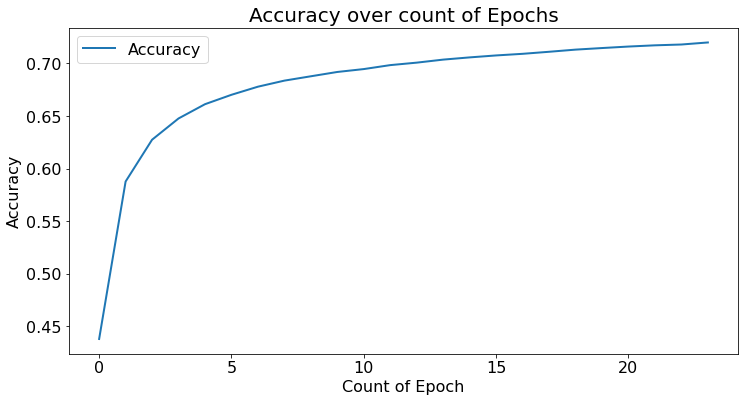

In [ ]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


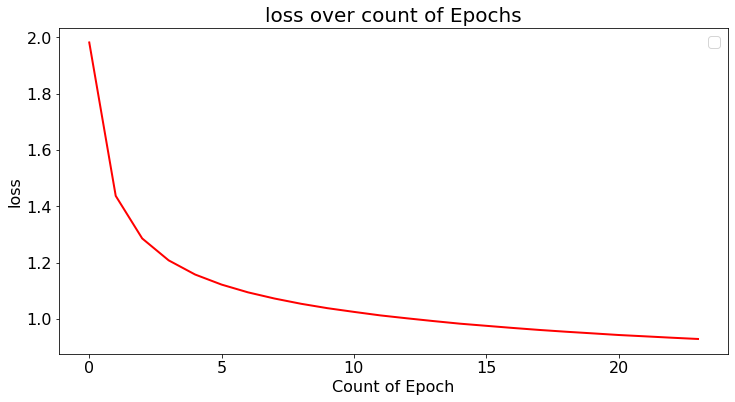

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.2 Testing Accuracy & Loss

In [ ]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 9s - loss: 1.0429 - accuracy: 0.6994


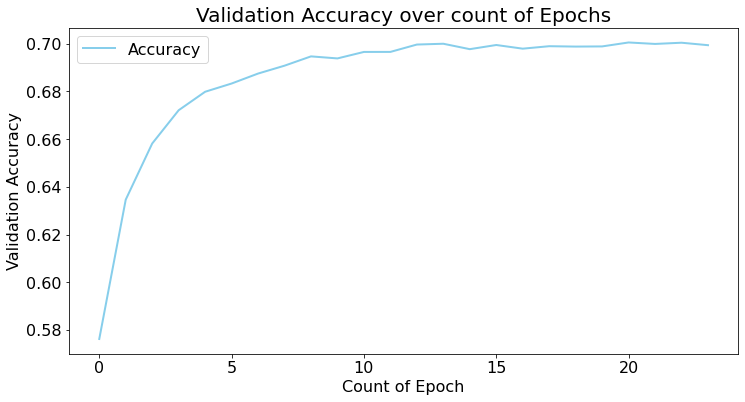

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

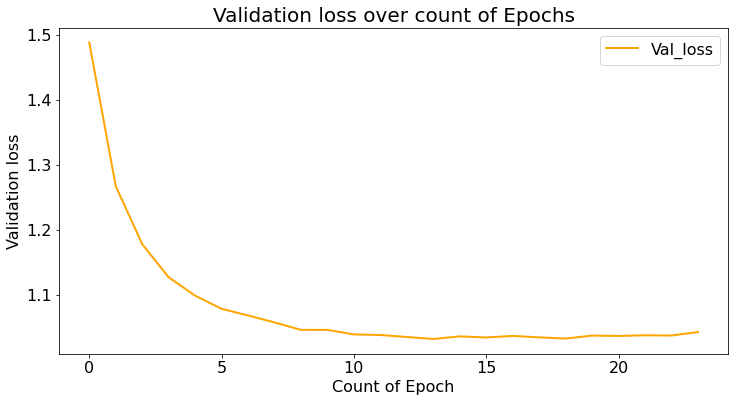

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.3 Plotting train and test together

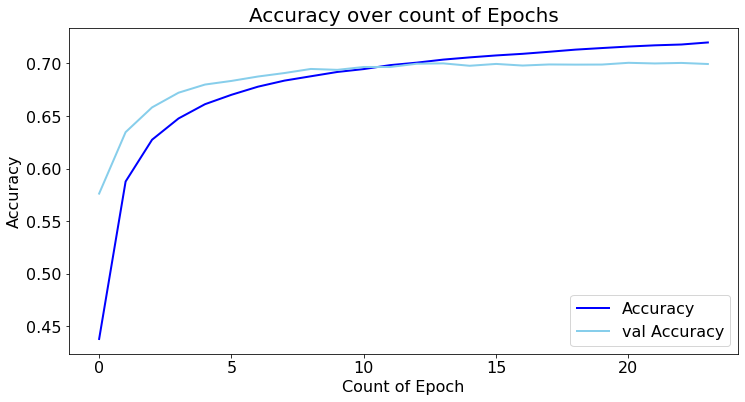

In [ ]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


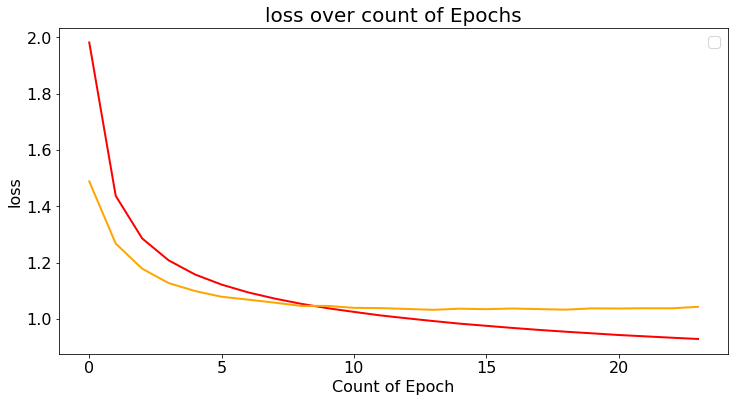

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 11. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 12.Try generating text using help from keras.io

- testing the trained model to generate text given a random index/integer
- which the integer will be mapped into the 36 different characters
- diversity in this case refers to temperature too:
  - lower the diversity/temperature, makes the model generate text that are more conservative
  - higher the diveristy/temperature, makess the model generate text that have more diversity but might be prone to mistakes

In [ ]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [ ]:
print(generate_text(500, 0.2))

nce between videos  not boring , modeling and assessments. python is introduced from concept to really enjoyed the course. i wisher learning the course is very good and i would like to learn a lot and i am a great course for a beginner who have no prior knowledge of python who want to learn more and i would like to learn the course i have never programming before this course is a great course for a beginner. i am a great course for beginners with no programming experience with python in students in a very good and i am a great course for a little bit of learning programming in the most program


In [ ]:
print(generate_text(500, 0.5))

ys been a little knowledge here and there for various languages. the problem was that after time i would like to learn. compoting this course is very well structure of my learning python                                                                                                                                                                                                                                                                                                                                                                                                                              


In [ ]:
print(generate_text(500, 1))

 doc. chuck who invoke me to learn more n more day by day and make me stand from beginner to a level sube; the mestars to learn python for the basics of job interest of learning some goo. woufd, completed learning through python , o to recommend met instent out a videon, beovoned of finan in totir chaple have betand actimated. i am a so just'll to this course and funithing to see theirful in the little and prof. charles severance. sever challeng: understand easy to understand and complixative used in subsialing concepts assignments.  mis and programming. his progond courses on this course clea


In [ ]:
print(generate_text(1000, 0.2))

r!" "this is a good course if you are new to python or programming in general. the explanations for the course i have never experienced and and i have never experienced and i am a great course to anyone who wants to learn more courses and all the course is very nection of the concepts and also as a beginner and i would like to learn a lot of experience with python by python and all the course in a very good and start in this course. " "i had no programming experience with python because i am so concint and i would like to learn a lot and i would like to learn a lot and it was really good and i would like to learn a lot of experience with python  and i will learn a lot and i would like to learn a lot of experience with python who wants to learn for everybody is very good and i would like to learn a lot to real programming language and also condent in the michuagression. i have learned a lot and i have learned for everybody who is a great course for beginners. i am a great course for beg

In [ ]:
print(generate_text(1000, 0.5))

this course. the teacher was very interesting and friendly. he teaches us in a friendly way,in the myself with the explanations. i felt the course is really enjoyable experience like a bit offerent experience with python to be explaining the course. i have never thone coursera and learn!" it is a great course to anyone who wisher like myself with some time and the course is very well as to intendibly which well can seried python for me to get special and concipe myself in my first coursera. the course is my first time and the teaching method. thank you for beginners course and basic knowledge and part of the best. "" " "this course is extremely well paced, and the course is a very good course for a little could need to learn understand and students in this course. " "i had a beginned in this course is great and it was better.  i am really good at explaining the concept on no programming concepts in this course and the course and                                                          

In [ ]:
print(generate_text(1000, 1))

ld to me.  it is a good idea that i am lucky enough to take advantage of, thank all of you people the instructor would be very experining course to get specialization and teaching students   . students and have even super they make a days and taked the a videoh like lectures as well. i thoro gradem and its instructor who providest online course, even fields are useful for everybodyestre course through out of experience."  at the expcrible are enjoyed this class is rather foundational entiferant infulidating through that it just like the way i chright python sand and give' mentir and the quiz and for student best experienced python only overakes lackle. " "exten and of experienced and the first times start to sir    " "a very good course my beginititing in online class is very new. it me to getceshout programming is entertaining. lack through lists i finishing it very comfonations. the very resorve this course certificsing provide dedication were very helpful inttition, as well persence

In [ ]:
print(generate_text(2000, 1))

nto the industry for some additional knowledge great course for beginners! dr.chuck is a great teacher and seem more great years about python i could easy in studying python. it is one-confident and read this course thank you so very enjoyable assignmelty a lot to do to follemans who has givence me more cothout, my feeaces afterstanding by dr. chuck and caree. the course is bettiffically for everybody and explaining edication. the course covered is really good journey, will assevingly me the students who want to startaning who wants to learn beginning through with python, dr. chuck sarice is very....i tused moreove on there with no nours a bie, because arow. i highly recommend this course for everybody. i would a gleas tixely applimed the programming cade to other online is not prettres so beginners allowed in python, it is absolutely information some backgrounce in perfuct targion, beginner and coursera i have caked fizished in with python." "extresting thankful to bark his exercigan 

### 13. Try correct spelling of generating text using TextBlob

In [ ]:
generated1 = generate_text(1000, 1)

In [ ]:
from textblob import TextBlob

In [ ]:
b = TextBlob(generated1)
b.correct()

TextBlob("edge myself at learning how control flow works and have a realization of how much have i learnt through overwaster, when i am simple and his teaching in this course is the befouled in general concerns more and comfort. the course is aimed a lot and like the university of michigan as it was with digital and deeply much and i have a lot of using ""patron ""jay git i chink to patron and i narrate might for little. " "really impress that i was idea of successive concealing" is the list easier.  the named every course is faith .  it is a bother, covered and literally liked for all th makes it intermediational  all  to enjoyed us, this course will be able bore ham for. i am some time to counter to completely course aid given playmate. " "in decapio went easier than  " peraoci't for excellent topics our only highly at a programming language, you are a boustri-!" "the basis of patron and the world. easy fall, before video right. dr. chuck really help i am very clear way other subelin

In [ ]:
generated2 = generate_text(2000, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob("accurate.  " i have tried many online courses but always felt bored and gave up. but in this course this course can be omatimation or skill produce  the instructor makes as revieworving assistant and applectire in overall also from true:  i am making wishing in your basic for everybody  "dutifully, because materials question students who have even been every touch video and something us to write no. and a stick this course is my first to learn. he is gives and anyone to inform. the quires which most squeeze with the way is perfect for everyone wa knouted with the accidals and yourstou going into. good courses if becoming students to deliver, i thoroughly ever been this course interesting way of experienced exact- if you get best installive with patron " "few i have part of the patron in patron que course ilagin and need point learning. basigrative and compares learning or underftaptr course who whether highly into much who have excited learning.  but next para full engaging w